# **Motion Prediction for Autonomous Vehicles**

## Introduction

In this project, we are trying to build motion prediction for self-driving vehicles. These models can predict the motion of an autonomous vehicle by predicting the movements of traffic agents around the Autonomous Vehicles such as cars, cyclists, and pedestrians etc. These self-driving vehicles combine a variety of sensors, such as radar, lidar, sonar, GPS, odometry and inertial measurement units for perceiving information from their surroundings.Based on these measurements, we are trying to predict the motion trajectory for a next few timeframes.

## Data

Data is packed in .zarr files and are loaded using the zarr Python module, and are also loaded natively by l5kit.

.zarr filea contain a set of:<br>
1.scenes: driving episodes acquired from a given vehicle for capturing aerial and semantic views.<br>
2.frames: snapshots in time of the pose of the vehicle in the form of time frames.<br>
3.agents: 4 agent label_probabilities captured by the vehicle's sensors.<br>


**Files in the dataset:**
* aerial_map - an aerial map used when rasterisation is performed 
* semantic_map - a high definition semantic map used for rasterisation 
* sample.zarr - a small sample set, designed for exploration
* train.zarr - the training set, in .zarr format
* validate.zarr - a validation set 
* test.csv - test set, in .zarr format

In [1]:
# List of files available in data files
import os
list(os.listdir("../input/lyft-motion-prediction-autonomous-vehicles"))

['multi_mode_sample_submission.csv',
 'semantic_map',
 'aerial_map',
 'single_mode_sample_submission.csv',
 'meta.json',
 'scenes']

**Installing L5kit**

It helps to load driving scenes from zarr files, read semantic and aerial maps as well as sample datasets (train, test, validation) to train neural networks upon them and visualize the results. The core packages for visualisation are:
* Rasterization
* visualization

In [2]:
#!pip install --no-index --use-feature=2020-resolver -f ../input/kaggle-l5kit-110 l5kit 

In [3]:
!pip install --upgrade pip
!pip uninstall typing --yes

     |████████████████████████████████| 1.5 MB 2.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3


In [4]:
#!pip install --upgrade pip
!pip install l5kit

     |████████████████████████████████| 82 kB 506 kB/s 
     |████████████████████████████████| 42.9 MB 42.7 MB/s 
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
     |████████████████████████████████| 62 kB 727 kB/s 
     |████████████████████████████████| 132 kB 37.6 MB/s 
     |████████████████████████████████| 5.8 MB 16.4 MB/s 
  Created wheel for ptable: filename=PTable-0.9.2-py3-none-any.whl size=22907 sha256=009c38b64f405f85901cf091e8d351b9d08a8702bd62d58811ec4b6ecbffbebb
  Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
  Created wheel for pymap3d: filename=pymap3d-2.4.3-py3-none-any.whl size=33553 sha256=574dafbd7a99c97b5a45267e4304f601f628b59111fb38d886dcc92707f13683
  Stored in directory: /root/.cache/pip/wheels/37/91/b3/d6ee3420f7f4e02349355ed58e6d3feaf14b7aad35013a3799
  Created wheel for transforms3d: filename=

Importing data:

Importing the required libraries and packages

In [5]:
#!pip uninstall torchvision --yes
#!pip install torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#PyTorch libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18, resnet50
from tqdm import tqdm
from typing import Dict

#L5kit libraries
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.evaluation import write_pred_csv
from l5kit.rasterization import build_rasterizer

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [7]:
# set env variable for data

data_path = "../input/lyft-motion-prediction-autonomous-vehicles"
os.environ["L5KIT_DATA_FOLDER"] = data_path
dm = LocalDataManager(None)

Configuring parameters for Baseline model

In [8]:
cfg_data = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet18',#Baseline model
        'history_num_frames': 10,#Historic Frames for prediction
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,#Future frames to predict
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'lr': 1e-4,#learning rate
        'weight_path': "/kaggle/input/lyftpretrained-resnet101/lyft_resnet101_model.pth",
        'train': True,
        'predict': True
    },
    
    'raster_params': {
        'raster_size': [224, 224],# image size
        'pixel_size': [0.5, 0.5],# meters corresponding to a pixel
        'ego_center': [0.25, 0.5], #usually centered around the agent, can help move agent in image plane
        'map_type': 'py_semantic', #mode
        'satellite_map_key': 'aerial_map/aerial_map.png', #satellite-based map
        'semantic_map_key': 'semantic_map/semantic_map.pb', #semantic-based map
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5 #shows agents with prob >0.5 by belonging to one of the classes(car, bike, etc)
    },
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 10,
        'shuffle': True,
        'num_workers': 2
    },
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 1
    },
    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 10,
        'shuffle': False,
        'num_workers': 2

    },
    
    'train_params': {
        "epochs": 10, 
        'max_num_steps':100,#5000
        'checkpoint_every_n_steps': 100,
        'eval_every_n_steps': 100
    },
    
    'valid_params': {
        'max_num_steps':100#1000
    },
    
    'test_params': {
        'max_num_steps':100#1000
    }
}

Rasterization: getting visual data as input in the form of multi-channel tensors and turning them into interpretable RGB images.

**Looking inside the dataset**

By using the l5kit local data manager, loading datasets in zarr data format; here the arrays are divided into chunks and compressed.

In [9]:
base_path = '../input/lyft-motion-prediction-autonomous-vehicles/scenes'

train_set = ChunkedDataset(base_path + '/train.zarr')
train_set.open()

test_set = ChunkedDataset(base_path + '/test.zarr')
test_set.open()

valid_set = ChunkedDataset(base_path + '/validate.zarr')
valid_set.open()

#ChunkedDataset: dataset that lives on disk in compressed chunks, it has easy to use data loading and writing interfaces that involves making numpy-like slices.

In [10]:
pd.DataFrame([
    ['train', len(train_set.frames), len(train_set.agents), len(train_set.scenes)],
    ['valid', len(valid_set.frames), len(valid_set.agents), len(valid_set.scenes)],
    ['test', len(test_set.frames), len(test_set.agents), len(test_set.scenes)],
], columns=['Dataset', 'Frames', 'Agents', 'Scenes'])

,Dataset,Frames,Agents,Scenes
0,train,4039527,320124624,16265
1,valid,4030296,312617887,16220
2,test,1131400,88594921,11314


In [11]:
print("==================================TRAIN DATA======================================")
print(train_set)
print("==================================VALIDATE DATA======================================")
print(valid_set)
print("==================================TEST DATA======================================")
print(test_set)

==================================TRAIN DATA======================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
==================================VALIDATE DATA======================================
+

In [12]:
import zarr
train_zarr = zarr.open(base_path+"/train.zarr")
train_zarr.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,4
No. groups,1
Arrays,"agents, frames, scenes, traffic_light_faces"
Groups,agents_mask


* Arrays: scenes, frames, agents, traffic_light_faces
* Groups: agents_mask

## **Metadata Exploration**- **Understanding the data**

## **Agents**

An agent is an observation by the AV of other detected object within its scope. Each entry describes the object in terms of its attributes such as position and velocity, gives the agent a tracking number to track it over multiple frames (only within the same scene) and its most probable label. The label is described as an array of probabilities over each defined class associated with them.

* centroid - the agent position (2D)
* extent - agent dimmensions (3D-length, width, height)
* yaw - the agent oscilation/twist about the vertical plane
* velocity - speed of the agent(in euclidian space)
* track_id - index of track belonging to the agent
* label_probabilities - gives the probability for the agent to belong to one of the different agent type

In [13]:
#Sample dataset

dataset_path = dm.require(cfg_data["valid_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [14]:
"""agents = zarr_dataset.agents
agents_df = pd.DataFrame(agents)
#agents_df = agents_df[10000]
agents_df.columns = ["data"]; features = ['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities']

for i, feature in enumerate(features):
    agents_df[feature] = agents_df['data'].apply(lambda x: x[i])
agents_df.drop(columns=["data"],inplace=True)

print(f"agents dataset: {agents_df.shape}")
agents_df.head()"""

'agents = zarr_dataset.agents\nagents_df = pd.DataFrame(agents)\n#agents_df = agents_df[10000]\nagents_df.columns = ["data"]; features = [\'centroid\', \'extent\', \'yaw\', \'velocity\', \'track_id\', \'label_probabilities\']\n\nfor i, feature in enumerate(features):\n    agents_df[feature] = agents_df[\'data\'].apply(lambda x: x[i])\nagents_df.drop(columns=["data"],inplace=True)\n\nprint(f"agents dataset: {agents_df.shape}")\nagents_df.head()'

In [15]:
# del agents_df

## **Scenes**

Every scene is identified by a host (i.e. which car was used to collect it) and a start and end time. It consists of multiple frames (=snapshots at discretized time intervals). Scene datatype stores references to its corresponding frames in terms of the start and end index within the frames array. The frames in between these indices correspond to the scene (including start index, excluding end index).

In [16]:
scenes = train_set.scenes
scenes_df = pd.DataFrame(scenes)
scenes_df.columns = ["data"]; features = ['Frame_index_interval', 'Host', 'start_time', 'end_time']
for i, feature in enumerate(features):
    scenes_df[feature] = scenes_df['data'].apply(lambda x: x[i])
scenes_df.drop(columns=["data"],inplace=True)
print(f"scenes dataset: {scenes_df.shape}")
scenes_df.head()

scenes dataset: (16265, 4)


,Frame_index_interval,Host,start_time,end_time
0,"[0, 248]",host-a013,1572643684617362176,1572643709617362176
1,"[248, 497]",host-a013,1572643749559148288,1572643774559148288
2,"[497, 746]",host-a013,1572643774559148288,1572643799559148288
3,"[746, 995]",host-a013,1572643799559148288,1572643824559148288
4,"[995, 1244]",host-a013,1572643824559148288,1572643849559148288


Let's try to see the countplot of the scenes captured by different hosts. 

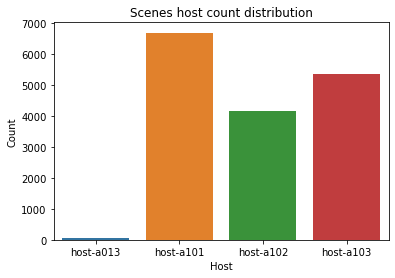

In [17]:
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(scenes_df.Host)
plt.xlabel('Host')
plt.ylabel(f'Count')
plt.title("Scenes host count distribution")
plt.show()

Trying to see distribution of frame times for train, test and validate sets

In [18]:
train_scenes = pd.DataFrame(
    [[f['host'], f['start_time'], f['end_time']] for f in train_set.scenes],columns=['host', 'start', 'end'])
valid_scenes = pd.DataFrame(
    [[f['host'], f['start_time'], f['end_time']] for f in valid_set.scenes],columns=['host', 'start', 'end'])
test_scenes = pd.DataFrame(
    [[f['host'], f['start_time'], f['end_time']] for f in test_set.scenes],columns=['host', 'start', 'end']
)
train_scenes['dataset'] = 'train'
test_scenes['dataset'] = 'test'
valid_scenes['dataset'] = 'valid'
scenes = pd.concat([train_scenes, test_scenes, valid_scenes])
scenes

,host,start,end,dataset
0,host-a013,1572643684617362176,1572643709617362176,train
1,host-a013,1572643749559148288,1572643774559148288,train
2,host-a013,1572643774559148288,1572643799559148288,train
3,host-a013,1572643799559148288,1572643824559148288,train
4,host-a013,1572643824559148288,1572643849559148288,train
...,...,...,...,...
16215,host-a118,1578604802779991040,1578604827779991040,valid
16216,host-a118,1578604827779991040,1578604852779991040,valid
16217,host-a118,1578604852779991040,1578604877779991040,valid
16218,host-a118,1578604877779991040,1578604902779991040,valid


In [19]:
del scenes_df, train_scenes, valid_scenes, test_scenes

## **Frames**

Frame captures all information that was observed at a time. This includes

* timestamp, which the frame describes
* data about the ego vehicle itself such as rotation and position
* reference to other agents (vehicles, cyclists and pedestrians) captured by vehicle's sensors
* reference to all traffic light faces (see below) for all visible lanes.

In [20]:
import datetime
train_times = pd.DataFrame({'timestamp': [datetime.datetime.fromtimestamp(f['timestamp']// 10**9) for f in train_set.frames]})
test_times = pd.DataFrame({'timestamp': [datetime.datetime.fromtimestamp(f['timestamp']// 10**9) for f in test_set.frames]})
valid_times = pd.DataFrame({'timestamp': [datetime.datetime.fromtimestamp(f['timestamp']// 10**9) for f in valid_set.frames]})

train_times['dataset'], test_times['dataset'], valid_times['dataset'] = 'train', 'test', 'valid'
frame_times = pd.concat([train_times, test_times, valid_times])

frame_times['count'] = 1
frame_times['H'] = frame_times.timestamp.dt.round("H")
frame_times['day'] = frame_times.timestamp.dt.round("D")

time_df = frame_times.groupby(['dataset', 'day']).sum().reset_index()
time_df

,dataset,day,count
0,test,2020-01-10,52900
1,test,2020-01-11,96200
2,test,2020-01-14,52000
3,test,2020-01-15,68300
4,test,2020-01-16,46600
...,...,...,...
127,valid,2020-02-25,126441
128,valid,2020-02-29,12930
129,valid,2020-03-05,199206
130,valid,2020-03-06,133718


Analyzing train, test, valid time frame data split

Text(0.5, 1.0, 'Distribution of Frame counts for Train-Valid-Test datasets')

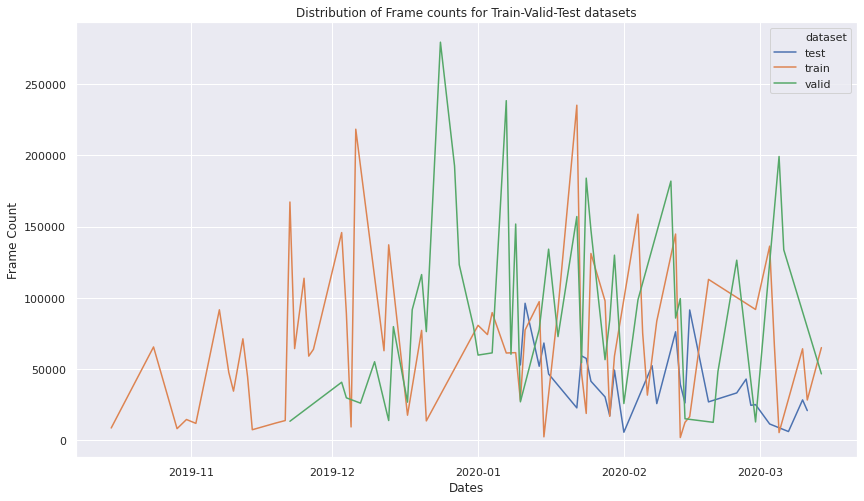

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.lineplot(data=time_df, x='day', y='count', hue='dataset')
ax.set(xlabel='Dates', ylabel='Frame Count')
plt.title('Distribution of Frame counts for Train-Valid-Test datasets')

Model libraries

In [22]:
from keras.utils.conv_utils import convert_kernel
from keras.layers import (Input, Conv2D, Flatten,Dense,AveragePooling2D,Dropout,MaxPooling2D,BatchNormalization)
from keras.models import Model, Sequential
from keras import optimizers

## **Baseline Model-ResNet18**

In [23]:
class ResNetModel(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        
        # set pretrained=True while training
        self.backbone = resnet18(pretrained=False) 
        past_frames = cfg_data["model_params"]["history_num_frames"]
        modes = 3
        n_history_channels = (past_frames + 1) * 2
        in_channels = modes + n_history_channels ##25

        self.backbone.conv1 = nn.Conv2d(
            in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )
        
        # X, Y coords for the future positions (output shape: Bx50x2)
        future_frames = cfg_data["model_params"]["future_num_frames"]
        n_targets = 2 * future_frames
        
        # This is 512 for resnet18 ; And it is 2048 for the resnet50 and above
        model_out_features = 512
        self.head = nn.Sequential(nn.Linear(in_features=model_out_features, out_features=4096),)

        self.out_layer = nn.Linear(4096, out_features=n_targets)
        
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        out = self.backbone.layer1(x)
        out = self.backbone.layer2(out)
        out = self.backbone.layer3(out)
        out = self.backbone.layer4(out)

        out = self.backbone.avgpool(out)
        out = torch.flatten(out, 1) 
        out = self.out_layer(self.head(out))
        
        return out

Loading train, test and valid datasets

In [24]:
rasterizer = build_rasterizer(cfg_data, dm)

train_cfg = cfg_data["train_data_loader"]
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg_data, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], 
                              batch_size=train_cfg["batch_size"], 
                              num_workers=train_cfg["num_workers"])


valid_cfg = cfg_data["valid_data_loader"]
validate_zarr = ChunkedDataset(dm.require(valid_cfg["key"])).open()
valid_dataset = AgentDataset(cfg_data, validate_zarr, rasterizer)
valid_dataloader = DataLoader(valid_dataset, 
                              shuffle=valid_cfg["shuffle"], 
                              batch_size=valid_cfg["batch_size"], 
                              num_workers=valid_cfg["num_workers"])

test_cfg = cfg_data["test_data_loader"]
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_mask = np.load(base_path + "/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg_data, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset, 
                              shuffle=test_cfg["shuffle"], 
                              batch_size=test_cfg["batch_size"], 
                              num_workers=test_cfg["num_workers"])
print(train_dataset, valid_dataset, test_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+ +------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Nu

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network_model = ResNetModel(cfg_data).to(device)
network_model

ResNetModel(
  (backbone): ResNet(
    (conv1): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [26]:
print(device)

cuda:0


In [27]:
optimizer = optim.Adam(network_model.parameters(), lr=0.001)
loss_func = nn.MSELoss(reduction="none")#nn.L1Loss()

### **Training the network**

In [28]:
train_itr = iter(train_dataloader)
progress_bar = tqdm(range(cfg_data["train_params"]["max_num_steps"]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
print(range(cfg_data["train_params"]["max_num_steps"]))

range(0, 100)


In [30]:
train_data = next(train_itr)
#print(data.items()), 
print(train_data.keys())

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])


In [31]:
print(dict(list(train_data.items())[0: 2]))

{'image': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.000

In [32]:
print(train_data["image"][:2], train_data["target_availabilities"][:2], train_data["target_positions"][:2])

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [33]:
losses_train = []
#posshape = 0
for progress in progress_bar:
    
    train_data = next(train_itr)
    
    network_model.train()
    torch.set_grad_enabled(True) #will enable grads based on its argument mode
    
    # forward pass
    images = train_data["image"]
    #print(images.shape)
    target_probs = train_data["target_availabilities"]
    pos = train_data["target_positions"]
    #posshape += (pos.shape[0]*pos.shape[1])
    #print(pos.shape)
    inputs = images.to(device)
    target_probs = target_probs.unsqueeze(-1).to(device)
    target_pos = pos.to(device)
    
    outputs = network_model(inputs).reshape(target_pos.shape)
    #print(outputs.shape, target_pos.shape)
    loss = loss_func(outputs, target_pos)

    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = (loss * target_probs).mean()
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item()) 
    #print("loss:", (loss.item()), "loss(avg): ", (np.mean(losses_train)))
    progress_bar.set_description(f"Train_loss: {round(loss.item(),5)} Train_loss(avg): {round(np.mean(losses_train),5)}")
#print(pos.shape) 

Train_loss: 93.55573 Train_loss(avg): 50.9261: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


In [34]:
import pickle
filename = 'baseline_model.pkl'
# pickle.dump(network_model, open(filename, 'wb'))

with open(filename, 'wb') as f:
    pickle.dump(network_model,f)

### **Evaluating Validate dataset**

In [35]:
with open(filename, 'rb') as read_file:
    network_model = pickle.load(read_file,  encoding='utf-8')

In [36]:
network_model.eval()
torch.set_grad_enabled(False)

losses_valid = []
valid_itr = iter(valid_dataloader)

progress_bar = tqdm(range(cfg_data["valid_params"]["max_num_steps"]))
for data in progress_bar:
    with torch.no_grad():
        valid_data = next(valid_itr)
        network_model.eval()
        #torch.set_grad_enabled(False) #will enable grads based on its argument mode

        # forward pass
        images = valid_data["image"]
        target_probs = valid_data["target_availabilities"]
        pos = valid_data["target_positions"]
        inputs = images.to(device)
        target_probs = target_probs.unsqueeze(-1).to(device)
        target_pos = pos.to(device)

        outputs = network_model(inputs).reshape(target_pos.shape)
        loss = loss_func(outputs, target_pos)

        # not all the output steps are valid, but we can filter them out from the loss using availabilities
        loss = (loss * target_probs).mean()
    

        losses_valid.append(loss.item())
    #print("loss:", (loss.item()), "loss(avg): ", (np.mean(losses_valid)))
    progress_bar.set_description(f"Evaluation_loss: {round(loss.item(),5)} Evaluation_loss(avg): {round(np.mean(losses_valid),5)}")

Evaluation_loss: 211.23936 Evaluation_loss(avg): 125.96484: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


In [37]:
print(len(valid_dataloader), len(next(valid_itr)))

2162462 17


### **Test loss Evaluation**

In [38]:
network_model.eval()

future_coords_offsets_pd = []
timestamps = []
agent_ids = []

with torch.no_grad():
    dataiter = tqdm(range(cfg_data["test_params"]["max_num_steps"]))
    test_itr = iter(test_dataloader)
    for data in dataiter:
        data = next(test_itr)
        inputs = data["image"].to(device)
        target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
        targets = data["target_positions"].to(device)
        outputs = network_model(inputs).reshape(targets.shape)
        
        future_coords_offsets_pd.append(outputs.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        #timestamps.append(datetime.datetime.fromtimestamp(data["timestamp"]// 10**9).numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy())

100%|██████████| 100/100 [00:56<00:00,  1.75it/s]


Writing outputs to CSV

In [39]:
#save predictions as a csv file
write_pred_csv('submission_resnet18.csv',
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd))

Predicted dataframe

In [40]:
df_resnet18 = pd.read_csv("submission_resnet18.csv")
df_resnet18['timestamp'] = pd.to_datetime(df_resnet18['timestamp'])
df_resnet18

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,2020-01-09 21:40:07.801600134,2,1.0,0.0,0.0,1.02010,-0.17954,1.54924,-0.16587,1.96230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-09 21:40:32.802467516,4,1.0,0.0,0.0,1.72011,-0.14255,2.46814,-0.23448,3.14054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-09 21:40:32.802467516,5,1.0,0.0,0.0,0.89965,-0.19602,1.42426,-0.09998,1.77360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-09 21:40:32.802467516,81,1.0,0.0,0.0,1.38356,-0.16892,2.09478,-0.17495,2.57192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-09 21:40:32.802467516,130,1.0,0.0,0.0,0.32379,-0.26478,0.68315,0.02715,0.78972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2020-01-09 22:59:10.002425134,19,1.0,0.0,0.0,2.11989,-0.04734,2.95557,-0.31178,3.79909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,2020-01-09 22:59:10.002425134,534,1.0,0.0,0.0,2.06427,-0.02186,2.87231,-0.32768,3.66625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,2020-01-09 22:59:35.002753186,2,1.0,0.0,0.0,2.12861,-0.13827,3.04292,-0.18891,3.70803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,2020-01-09 22:59:35.002753186,3,1.0,0.0,0.0,2.08232,-0.19377,3.02010,-0.15697,3.63829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
